In [1]:
pip install nnAudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install pandas

In [3]:
import matplotlib.pyplot as plt # For plots
from matplotlib.gridspec import GridSpec
import numpy as np
import warnings #Ignore Warnings
from random import shuffle
import tensorflow as tf #Model and Dataset
from sklearn.model_selection import train_test_split
from scipy import signal
import pandas as pd # Panel Data
warnings.filterwarnings("ignore")

train_labels = pd.read_csv("/kaggle/input/g2net-gravitational-wave-detection/training_labels.csv")
sample_submission = pd.read_csv("/kaggle/input/g2net-gravitational-wave-detection/sample_submission.csv")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Get the Path

In [4]:
def id2path(idx, is_train = True):
    path = "/kaggle/input/g2net-gravitational-wave-detection"
    
    if is_train:
        path += "/train/" + idx[0] + "/" + idx[1] + "/" + idx[2] + "/" + idx + ".npy"
        
    else:
        path += "/test/" + idx[0] + "/" + idx[1] + "/" + idx[2] + "/" + idx + ".npy"
        
    return path

# Increase Dimension whit Constant Q-Transform

In [5]:
from nnAudio.Spectrogram import CQT1992v2 #transforming data series to frequency domain
import torch

def increase_dimension(idx, is_train, transform = CQT1992v2(sr = 2048, hop_length = 64, fmin = 20, fmax = 500)):
    wave = np.load(id2path(idx, is_train))
    wave = np.concatenate(wave, axis = 0)
    bHP, aHP = signal.butter(8, (20, 500), btype='bandpass', fs=2048)
    window = signal.tukey(4096*3, 0.2)
    wave *= window
    wave = signal.filtfilt(bHP, aHP, wave)
    wave = wave / np.max(wave)
    wave = torch.from_numpy(wave).float()
    image = transform(wave)
    image = np.array(image)
    image = np.transpose(image, (1, 2, 0))
    
    return image

CQT kernels created, time used = 0.0845 seconds


In [6]:
increase_dimension(train_labels["id"][0], is_train = True)

array([[[1.71383023e-02],
        [2.15356778e-02],
        [3.09020374e-02],
        ...,
        [3.96850482e-02],
        [3.64460088e-02],
        [3.53588685e-02]],

       [[4.19120751e-02],
        [4.27369438e-02],
        [4.48097289e-02],
        ...,
        [4.08827178e-02],
        [2.58283038e-02],
        [1.85664613e-02]],

       [[6.70719380e-03],
        [6.95151836e-03],
        [8.51236563e-03],
        ...,
        [5.94172254e-02],
        [5.05628213e-02],
        [4.74436581e-02]],

       ...,

       [[1.51597997e-05],
        [8.97485443e-05],
        [1.84204939e-04],
        ...,
        [5.67970448e-04],
        [9.99843687e-05],
        [1.93693177e-05]],

       [[1.31730276e-05],
        [1.49926680e-04],
        [2.22508519e-04],
        ...,
        [6.89916022e-04],
        [6.07860020e-05],
        [2.45495539e-06]],

       [[1.14990835e-05],
        [9.89389446e-05],
        [2.03533637e-04],
        ...,
        [5.79114479e-04],
        [9.9785

# Visualize the data

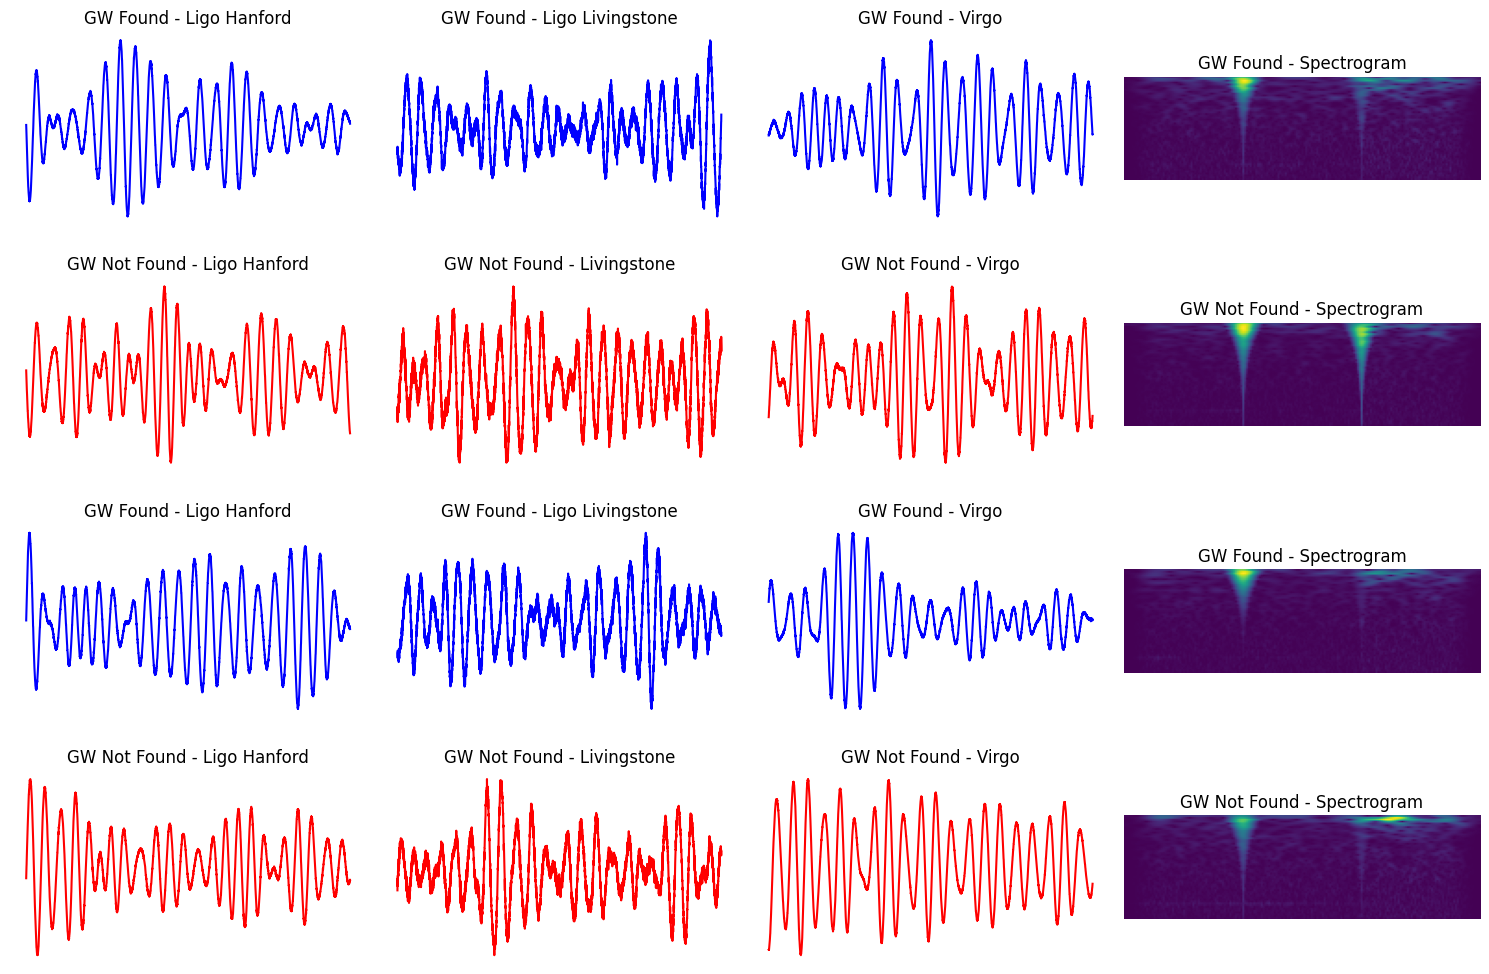

In [7]:
targets = train_labels[train_labels["target"] == 0]["id"].head(2)
no_targets = train_labels[train_labels["target"] == 1]["id"].head(2)
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(4, 4, figure=fig)

for i, (target, no_target) in enumerate(zip(targets, no_targets)):
    # Subplots for GWs
    ax1 = fig.add_subplot(gs[i*2, 0])
    ax1.plot(np.load(id2path(target))[1, :], color='blue')
    ax1.set_title("GW Found - Ligo Hanford")
    ax1.set_axis_off()

    ax2 = fig.add_subplot(gs[i*2, 1])
    ax2.plot(np.load(id2path(target))[2, :], color='blue')
    ax2.set_title("GW Found - Ligo Livingstone")
    ax2.set_axis_off()

    ax3 = fig.add_subplot(gs[i*2, 2])
    ax3.plot(np.load(id2path(target))[0, :], color='blue')
    ax3.set_title("GW Found - Virgo")
    ax3.set_axis_off()
    
    ax4 = fig.add_subplot(gs[i*2, 3])
    ax4.imshow(increase_dimension(target, is_train=True))
    ax4.set_title("GW Found - Spectrogram")
    ax4.set_axis_off()
    

    # Subplot if GW Not Found
    ax5 = fig.add_subplot(gs[i*2 + 1, 0])
    ax5.plot(np.load(id2path(no_target))[1, :], color='red')
    ax5.set_title("GW Not Found - Ligo Hanford")
    ax5.set_axis_off()

    ax6 = fig.add_subplot(gs[i*2 + 1, 1])
    ax6.plot(np.load(id2path(no_target))[2, :], color='red')
    ax6.set_title("GW Not Found - Livingstone")
    ax6.set_axis_off()

    ax7 = fig.add_subplot(gs[i*2 + 1, 2])
    ax7.plot(np.load(id2path(no_target))[0, :], color='red')
    ax7.set_title("GW Not Found - Virgo")
    ax7.set_axis_off()

    ax8 = fig.add_subplot(gs[i*2 + 1, 3])
    ax8.imshow(increase_dimension(no_target, is_train=True))
    ax8.set_title("GW Not Found - Spectrogram")
    ax8.set_axis_off()

plt.tight_layout()
plt.show()



## Note that the gravitational wave signal cannot be seen with the naked eye,i.e,just by looking at the waveform,we cannot directly see the gravitational wave without the spectrogram

# Batch Data

In [8]:
import math
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, data, y = None, batch_size = 256, shuffle = True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        if y is not None:
            self.is_train = True
        else:
            self.is_train = False
            
        self.y = y
        
    def __len__(self):
        return math.ceil(len(self.data)/ self.batch_size)
    
    def __getitem__(self, ids):
        batch_data = self.data[ids * self.batch_size : (ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size : (ids + 1) * self.batch_size]
            
        batch_x = np.array([increase_dimension(x, self.is_train) for x in batch_data])
        batch_x = np.stack(batch_x)
        
        if self.is_train:
            return batch_x, batch_y
        else:
            return batch_x

    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.data, self.y))
            shuffle(ids_y)
            self.data, self.y = list(zip(*ids_y))
        
        

In [9]:
train_idx =  train_labels['id'].values
y = train_labels['target'].values
test_idx = sample_submission['id'].values

x_train,x_valid,y_train,y_valid = train_test_split(train_idx,y,test_size=0.05,random_state=42,stratify=y)

train_dataset = Dataset(x_train,y_train)
valid_dataset = Dataset(x_valid,y_valid)
test_dataset = Dataset(test_idx)

In [10]:
pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


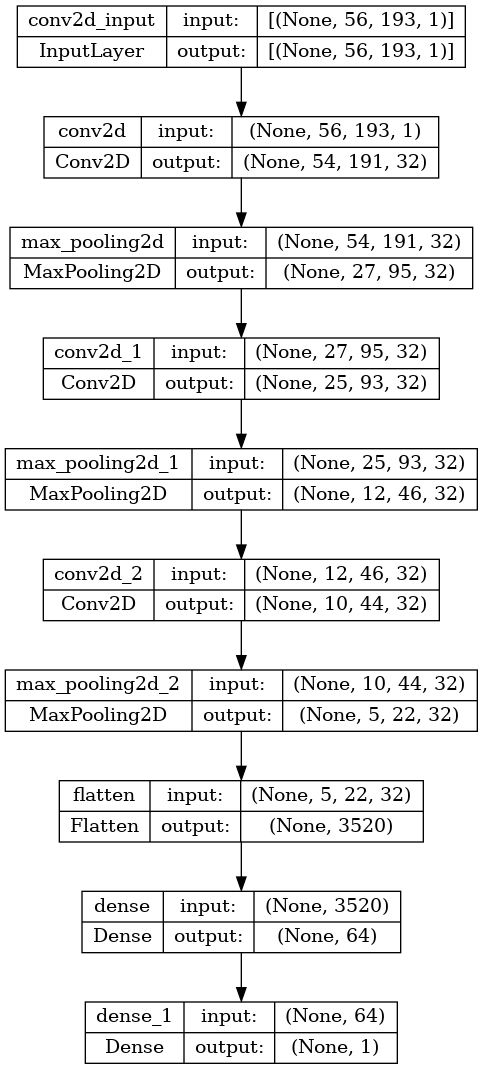

In [11]:
def create_model():
    Conv1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3) ,input_shape = [56, 193, 1], activation = "elu")
    Maxpooling1 = tf.keras.layers.MaxPool2D()
    Conv2 = tf.keras.layers.Conv2D(filters = 32,  kernel_size = (3, 3), activation = "elu")
    Maxpooling2 = tf.keras.layers.MaxPool2D()
    Conv3 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "elu")
    Maxpooling3 = tf.keras.layers.MaxPool2D()
    flatten = tf.keras.layers.Flatten()
    Dense1 = tf.keras.layers.Dense(64, activation = "relu")
    dense2 = tf.keras.layers.Dense(1, activation = "sigmoid")
    
    model = tf.keras.Sequential([Conv1, Maxpooling1,Conv2, Maxpooling2, Conv3, Maxpooling3, flatten ,Dense1, dense2])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
    
    return model
    
model = create_model()

from tensorflow.keras.utils import plot_model
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
plot_model(model, to_file='model.png', show_shapes=True)

    

In [12]:
model.fit(train_dataset, epochs = 2, validation_data = valid_dataset)

Epoch 1/2
2079/2079 [==============================] - 11383s 5s/step - loss: 0.4924 - auc: 0.8200 - val_loss: 0.4760 - val_auc: 0.8365
Epoch 2/2
2079/2079 [==============================] - 12109s 6s/step - loss: 0.4619 - auc: 0.8401 - val_loss: 0.4621 - val_auc: 0.8432


In [ ]:
preds = model.predict(test_dataset)
preds = preds.reshape(-1)
submission = pd.DataFrame({'id':sample_submission['id'],'target':preds})
submission.to_csv('submission.csv',index=False)

  9/883 [..............................] - ETA: 1:11:13